# Homogén adatok átalakítása modell tanításhoz

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
import random
import calendar
from datetime import datetime
'''
def pick_random_days(year):
    random_days = {}
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        random_days[calendar.month_name[month]] = random.sample(range(1, days_in_month + 1), 3)
        date = datetime(year, month, day)
    return random_days

year = 2024
random_days = pick_random_days(year)
random.seed(42)
for month, days in random_days.items():
    
    print(f"{month}: {days}")
    
''' 
import random
from datetime import datetime, timedelta
random.seed(42)
def random_dates(years,validation_day_no, size_reducing_day_no):
    all_random_dates=validation_day_no+size_reducing_day_no
    dates = []
    size_reducing_dates=[]
    for year in years:
        for month in range(1, 13):
            for i in range(all_random_dates):
                # Generate a random day in the current month
                day = random.randint(1, 28)  # To avoid issues with different month lengths
                date = datetime(year, month, day).date()
                if i>=validation_day_no:
                    size_reducing_dates.append(date)
                else:
                    dates.append(date)
    return dates,size_reducing_dates

# Example usage
years = [2022,2023]
random_days,days_to_keep = random_dates(years,3,10)
for date in random_days:
    print(date)

2022-01-21
2022-01-04
2022-01-01
2022-02-03
2022-02-19
2022-02-14
2022-03-23
2022-03-21
2022-03-23
2022-04-26
2022-04-06
2022-04-23
2022-05-04
2022-05-12
2022-05-28
2022-06-03
2022-06-18
2022-06-10
2022-07-22
2022-07-08
2022-07-25
2022-08-27
2022-08-12
2022-08-06
2022-09-21
2022-09-06
2022-09-18
2022-10-22
2022-10-11
2022-10-27
2022-11-03
2022-11-07
2022-11-19
2022-12-05
2022-12-08
2022-12-24
2023-01-05
2023-01-17
2023-01-16
2023-02-14
2023-02-20
2023-02-03
2023-03-24
2023-03-04
2023-03-22
2023-04-15
2023-04-01
2023-04-24
2023-05-27
2023-05-21
2023-05-17
2023-06-20
2023-06-11
2023-06-16
2023-07-03
2023-07-03
2023-07-24
2023-08-18
2023-08-06
2023-08-09
2023-09-23
2023-09-10
2023-09-13
2023-10-11
2023-10-01
2023-10-19
2023-11-03
2023-11-02
2023-11-28
2023-12-24
2023-12-19
2023-12-19


In [8]:
'''import random
random.seed(45)   
print(random.random())
print(random.random())
random.seed(45)   
print(random.random())
print(random.random())
'''

'import random\nrandom.seed(45)   \nprint(random.random())\nprint(random.random())\nrandom.seed(45)   \nprint(random.random())\nprint(random.random())\n'

In [3]:
#data_root = "data/"
from config import data_root
#datafn= "data.csv"

In [28]:
import numpy as np
#raw_data =load_data(data_root+datafn)
raw_data=pd.read_pickle(data_root+'data.pkl')


In [5]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,IDO,TENY_IDO,TERV_IDOTARTAM (m),KESES (m),OSSZ_KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,ELOZO_SZAKASZ_TERV_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,2022-01-01 00:25:00,2022-01-01 00:25:24,0.0,0.000000,0.400000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,2022-01-01 00:29:00,2022-01-01 00:30:10,4.0,0.766667,1.166667,4.766667,0.087452,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,2022-01-01 00:30:00,2022-01-01 00:30:40,1.0,-0.500000,0.666667,0.500000,-0.333333,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,2022-01-01 00:35:00,2022-01-01 00:34:55,5.0,-0.750000,-0.083333,4.250000,-0.081081,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,2022-01-01 00:36:00,2022-01-01 00:36:09,1.0,0.233333,0.150000,1.233333,0.104478,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [11]:
#raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
raw_data.isnull().values.any() 

False

In [7]:
raw_data.isnull().any()

VONATSZAM                                  False
KOZLEKEDESI_NAP                            False
IDO                                        False
TENY_IDO                                   False
TERV_IDOTARTAM (m)                         False
KESES (m)                                  False
OSSZ_KESES (m)                             False
TENY_IDOTARTAM (m)                         False
RELATIV_KESES                              False
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           False
ELOZO_SZAKASZ_KESES (m)                    False
ELOZO_SZAKASZ_RELATIV_KESES                False
ID                                         False
CSATL_MAX_KESES (m)                        False
MENETREND_IDO (m)                          False
tx                                         False
t                                          False
tn                                         False
r                                          False
LINE                                       False
Érintett objektum tí

In [24]:
raw_data.isnull().any(axis=1).sum()


0

In [8]:
raw_data.isin([np.inf, -np.inf]).any() 


VONATSZAM                                  False
KOZLEKEDESI_NAP                            False
IDO                                        False
TENY_IDO                                   False
TERV_IDOTARTAM (m)                         False
KESES (m)                                  False
OSSZ_KESES (m)                             False
TENY_IDOTARTAM (m)                         False
RELATIV_KESES                              False
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           False
ELOZO_SZAKASZ_KESES (m)                    False
ELOZO_SZAKASZ_RELATIV_KESES                False
ID                                         False
CSATL_MAX_KESES (m)                        False
MENETREND_IDO (m)                          False
tx                                         False
t                                          False
tn                                         False
r                                          False
LINE                                       False
Érintett objektum tí

In [9]:
np.isinf(raw_data[['RELATIV_KESES','ELOZO_SZAKASZ_RELATIV_KESES','ELOZO_VONAT_RELATIV_KESES']]).values.sum()

0

In [10]:
raw_data[np.isinf(raw_data['RELATIV_KESES'])] 

,VONATSZAM,KOZLEKEDESI_NAP,IDO,TENY_IDO,TERV_IDOTARTAM (m),KESES (m),OSSZ_KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,ELOZO_SZAKASZ_TERV_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT


VONATSZAM                                  False
KOZLEKEDESI_NAP                            False
IDO                                        False
TENY_IDO                                   False
TERV_IDOTARTAM (m)                         False
KESES (m)                                  False
OSSZ_KESES (m)                             False
TENY_IDOTARTAM (m)                         False
RELATIV_KESES                               True
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           False
ELOZO_SZAKASZ_KESES (m)                    False
ELOZO_SZAKASZ_RELATIV_KESES                 True
ID                                         False
CSATL_MAX_KESES (m)                        False
MENETREND_IDO (m)                          False
tx                                         False
t                                          False
tn                                         False
r                                          False
LINE                                       False
Érintett objektum tí

In [ ]:
#raw_data=raw_data.dropna()

In [12]:
#raw_data[['ELOZO_VONAT_KESES (m)','ELOZO VONAT RELATIV KESES','ELOZO_KESES','RELATIV_KESES']].fillna(datetime.timedelta(0), inplace=True)

#raw_data['VONAL STATUSZ VALTOZOTT'].fillna(False, inplace=True)

C:\Users\ELTE\AppData\Local\Temp\ipykernel_26572\3168957026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[['ELOZO VONAT KESES','ELOZO VONAT RELATIV KESES','ELOZO_KESES','RELATIV_KESES']].fillna(0.0, inplace=True)
C:\Users\ELTE\AppData\Local\Temp\ipykernel_26572\3168957026.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_d

In [10]:
#rows_with_missing_values=raw_data[raw_data.isnull().any(axis=1)]
#rows_with_missing_values.head()

In [11]:
#rows_with_missing_values.shape

In [12]:
#rows_with_missing_values.head()

In [13]:
#raw_data.dropna( inplace=True)


In [29]:
#raw_data['KOZLEKEDESI_NAP']=pd.to_datetime(raw_data['ELOZO_ESEMENY_IDO']).dt.date
df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]




C:\Users\ELTE\AppData\Local\Temp\ipykernel_20348\2797493571.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]


In [12]:
df_to_validate_orig['ID'].unique()

array(['10033-10033', '10033-10082', '10082-10082', '10082-10124',
       '10124-10124', '10124-10207', '10207-10207', '10207-40253',
       '40253-40253', '40253-1404', '1404-1404', '1404-1408', '1408-1408',
       '1408-1412', '1412-1412', '1412-1420', '1420-1420', '1420-1428',
       '1428-1428', '1428-1433', '1433-1433', '1433-1438', '1438-1438',
       '1438-46052', '46052-46052', '46052-1440', '1440-1442',
       '1442-1446', '1446-1446', '1446-1453', '1453-1453', '1453-1457',
       '1457-1457', '1457-1461', '1461-1461', '1461-40261', '40261-40261',
       '40261-1487', '1487-1487', '1487-1495', '1495-1495', '1495-40824',
       '40824-1503', '1503-1503', '1503-1511', '1511-1511', '1511-1503',
       '1503-40824', '40824-1495', '1495-1487', '1487-40261',
       '40261-1461', '1461-1457', '1457-1453', '1453-1446', '1446-1442',
       '1442-1440', '1440-46052', '46052-1438', '1438-1433', '1433-1428',
       '1428-1420', '1420-1412', '1412-1408', '1408-1404', '1404-40253',
       '

In [30]:
df_to_validate_orig.to_pickle(data_root+'validation_orig.pkl')
del df_to_validate_orig

In [9]:
raw_data.dtypes

VONAL                                       object
VONATSZAM                                    int64
VONTATO_TIPUS                                int64
ELOZO_ESEMENY_IDO                           object
MENETREND_IDO                               object
OSSZ_KESES                                  object
ELOZO_KESES                                 object
KESES                                       object
RELATIV_KESES                              float64
TERV_IDOTARTAM (m)                         float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
ID                                          object
Kizárásszám                                 object
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza              

In [17]:
# nem kellene már...
import datetime
def convert_time_to_minute(input):
    if isinstance(input,datetime.time):
        return float(input.hour*60+input.minute)
    #TODO does totalseconds return some decent value for negativ timedelta? 
    # ANS: it is good
    if isinstance(input,datetime.timedelta):
        ret = input.total_seconds()/60
       # if datetime.timedelta(0)>input:
       #     return -ret
        return ret
    if isinstance(input,float):
        return input
    return -1.0

In [14]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,IDO,TENY_IDO,TERV_IDOTARTAM (m),KESES (m),OSSZ_KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,ELOZO_SZAKASZ_TERV_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,2022-01-01 00:25:00,2022-01-01 00:25:24,0.0,0.000000,0.400000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,2022-01-01 00:29:00,2022-01-01 00:30:10,4.0,0.766667,1.166667,4.766667,0.087452,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,2022-01-01 00:30:00,2022-01-01 00:30:40,1.0,-0.500000,0.666667,0.500000,-0.333333,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,2022-01-01 00:35:00,2022-01-01 00:34:55,5.0,-0.750000,-0.083333,4.250000,-0.081081,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,2022-01-01 00:36:00,2022-01-01 00:36:09,1.0,0.233333,0.150000,1.233333,0.104478,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [18]:
# átalakítjuk időt percekké

In [31]:
#atzt tartjuk meg, ami kell a traininghez és predikcióhoz
def prepare_for_ml_models(raw_data):
    to_drop=['VONATSZAM','IDO',"TENY_IDO","RELATIV_KESES","ID","OSSZ_KESES (m)",'TENY_IDOTARTAM (m)',"Kezdés","Befejezés"]
    #raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']] = raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']].map(convert_time_to_minute)
    raw_data.drop(to_drop,axis=1,inplace=True)   
    raw_data['VONAL_STATUSZ_VALTOZOTT']=raw_data['VONAL_STATUSZ_VALTOZOTT'].astype(float)
    raw_data.fillna(0.0,inplace=True)
    
prepare_for_ml_models(raw_data)

In [20]:
#TODO boolean vs categorical?
#TODO Vonal, Line mit kellene kezdeni velük? kicsit kölséges használni őket..
#raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']]=raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']].astype("category")

# sklearn nem bír  category-kal
#raw_data.drop(columns=['VONATSZAM','VONAL','VONTATO_TIPUS'],inplace=True)

# vonatszám kell majd spearman-hez
#raw_data.drop(columns=['VONAL','VONTATO_TIPUS'],inplace=True)


In [24]:

#
#raw_data=raw_data.drop(columns=['TENY_IDOTARTAM (m)',"Kezdés","Befejezés"])


In [23]:

raw_data.dtypes


TERV_IDOTARTAM (m)                         float64
KESES (m)                                  float64
TENY_IDOTARTAM (m)                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           float64
ELOZO_SZAKASZ_KESES (m)                    float64
ELOZO_SZAKASZ_RELATIV_KESES                float64
CSATL_MAX_KESES (m)                        float64
MENETREND_IDO (m)                          float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása                     float64
I                              

In [32]:
raw_data.tail()

,KOZLEKEDESI_NAP,TERV_IDOTARTAM (m),KESES (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),MENETREND_IDO (m),tx,t,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
100111,2023-12-31,0.0,0.200000,5.0,0.250000,0.024390,0.0,489.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,1.000000,0.0
100112,2023-12-31,5.0,-0.466667,0.0,0.200000,1.000000,0.0,494.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.766667,-0.083032,0.0
100113,2023-12-31,0.0,0.300000,5.0,-0.466667,-0.048951,0.0,494.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383333,1.000000,0.0
100114,2023-12-31,11.0,0.166667,0.0,0.300000,1.000000,0.0,505.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816667,0.035793,0.0
100115,2023-12-31,0.0,0.000000,11.0,0.166667,0.007519,0.0,505.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.383333,0.089924,0.0


In [33]:
df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
#NEM HASZNÁLJUK AZ EGÉSZ ADATOT
df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]
del raw_data

C:\Users\ELTE\AppData\Local\Temp\ipykernel_20348\3482023882.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
C:\Users\ELTE\AppData\Local\Temp\ipykernel_20348\3482023882.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]


In [34]:
#ez is kell spearmann-hez
df_to_validate.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)
df_remaining.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)


In [36]:
#df_to_validate.drop(columns=['ID'],inplace=True)
#df_remaining.drop(columns=['ID'],inplace=True)
#raw_data.to_csv(data_root+'preprocessed_data.csv', index=False)
df_to_validate.to_csv(data_root+'validation_data.csv', index=False)
df_remaining.to_csv(data_root+'train_test_data.csv', index=False)



In [37]:
del df_to_validate
del df_remaining

In [ ]:
pori

# Modellek tanítása

A modellek tanításához elég innentől futtatni.

In [1]:
import pandas as pd
data_root = "data/"

raw_data=pd.read_csv(data_root+'train_test_data.csv')
#raw_data['VONAL STATUSZ VALTOZOTT']=raw_data['VONAL STATUSZ VALTOZOTT'].head().astype(float)



In [2]:

raw_data.columns


Index(['TERV_IDOTARTAM (m)', 'KESES (m)', 'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)',
       'ELOZO_SZAKASZ_KESES (m)', 'ELOZO_SZAKASZ_RELATIV_KESES',
       'CSATL_MAX_KESES (m)', 'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r',
       'LINE', 'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása', 'I',
       'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'],
      dtype='object')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def split_train_test(data, normalize=False):
    raw_data=data.copy()
    X_scaler=None
    y_scaler=None
    pd_y= raw_data[['KESES (m)']]
    pd_X = raw_data.drop(columns=['KESES (m)'])
    if 'RELATIV_KESES' in raw_data.columns:
        pd_X.drop(columns=['RELATIV_KESES'],inplace=True)
    if normalize:
        X_scaler = MinMaxScaler()
        pd_X[pd_X.columns] = X_scaler.fit_transform(pd_X[pd_X.columns])
        y_scaler=MinMaxScaler()
        pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])
   
    '''
    if normalize:
        scaler = MinMaxScaler()
        pd_X[pd_X.columns] = scaler.fit_transform(pd_X[pd_X.columns])
    '''
    X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.3, random_state=44)
    return X_train, X_test, y_train, y_test,X_scaler,y_scaler

In [4]:
X_train, X_test, y_train, y_test,_,_ = split_train_test(raw_data)
#X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
#X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)

''''
TrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]
X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
TeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]
X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
'''

"'\nTrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\nTeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\n"

In [5]:
X_train.head()

,TERV_IDOTARTAM (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),MENETREND_IDO (m),tx,t,tn,r,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
603754,2.0,1.0,0.166667,0.076923,0.000000,709.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.433333,-0.121495,0.0
745736,1.0,2.0,-0.483333,-0.137441,-12.150000,389.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.033333,-0.016949,0.0
893882,3.0,0.0,0.616667,1.000000,0.000000,1237.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.062500,0.0
161937,1.0,1.0,-0.283333,-0.165049,12.183333,483.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.233333,-0.132075,0.0
74774,0.0,2.0,-1.083333,-0.371429,179.400000,472.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316667,1.000000,0.0


# DecisionTreeRegressor

In [7]:
max_depth=[]

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/
def train_DRT(X_train, X_test, y_train):
    
    # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'criterion':["squared_error","absolute_error" ]
    }
    dtree_reg = DecisionTreeRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(best_params)
    predictions = model.predict(X_test)
    return model, predictions
'''
def train_DRTF(X_train, X_test, y_train):
    
        # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dtree_reg = RandomForestRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    predictions = model.predict(X_test)
    return model, predictions
'''
model, predictions = train_DRT(X_train,X_test, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [120]:
'''
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8), dpi=150)
plot_tree(model, feature_names=pd_X.columns);
'''

'\nfrom sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(10,8), dpi=150)\nplot_tree(model, feature_names=pd_X.columns);\n'

$$\text{SMAPE} = \frac{100}{n} \sum_{t=1}^n \frac{\left|F_t-A_t\right|}{(|A_t|+|F_t|)/2}$$

In [22]:

def evaluate_model(X_test, y_test, predictions):
    eval_df=pd.concat([X_test[['TERV_IDOTARTAM (m)']],y_test],axis=1)
    eval_df['predictions']=predictions
    eval_df['AE']=abs(eval_df['KESES (m)']+eval_df['predictions'])
    eval_df['Tény']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES (m)']
    eval_df['Pred']=eval_df['TERV_IDOTARTAM (m)']+eval_df['predictions']
    eval_df=eval_df[eval_df['TERV_IDOTARTAM (m)']>0]
    eval_df['MAPE (KESES)']=abs((eval_df['Tény']-eval_df['Pred'])/eval_df['Tény']) *100
    eval_df['MAPE (MENETIDO)']=abs((eval_df['KESES (m)']-eval_df['predictions'])/eval_df['KESES (m)']) *100
    eval_df['SMAPE (KESES)']=abs(eval_df['predictions']-eval_df['KESES (m)'])/((abs(eval_df['KESES (m)'])+abs(eval_df['predictions']))/2) *100
    eval_df['SMAPE (MENETIDO)']=abs(eval_df['Pred']-eval_df['Tény'])/((abs(eval_df['Tény'])+abs(eval_df['Pred']))/2) *100


    return eval_df 

In [23]:
eval_df = evaluate_model(X_test, y_test, predictions)


In [67]:
eval_df[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE1 (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
count,311547.000000,311547.000000,3.115030e+05,3.108410e+05,310841.000000,311503.000000
mean,-0.008364,1.007444,inf,inf,64.925939,11.447243
std,0.906503,1.379481,NaN,NaN,72.176421,17.452423
min,-6.133333,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,-0.416667,0.298065,1.802930e+00,7.864374e+00,7.942238,1.805451
50%,-0.116667,0.649265,5.277113e+00,2.903211e+01,30.685528,5.265247
75%,0.216667,1.100000,1.342916e+01,8.941799e+01,106.896552,13.300648
max,30.666667,48.466667,inf,inf,200.000000,200.000000


In [73]:
eval_df_XXX=evaluate_model(X_test, y_test, np.zeros(predictions.shape))


In [74]:
eval_df_XXX[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE1 (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
count,311547.000000,3.115470e+05,3.115470e+05,311547.0,311547.0,3.115470e+05
mean,-0.008364,5.407484e-01,1.433058e+05,100.0,200.0,3.137542e+01
std,0.906503,7.276047e-01,1.122570e+07,0.0,0.0,2.875404e+01
min,-6.133333,4.569689e-08,2.176043e-07,100.0,200.0,2.176043e-07
25%,-0.416666,1.666659e-01,8.597277e+00,100.0,200.0,8.695600e+00
50%,-0.116667,3.500004e-01,2.499995e+01,100.0,200.0,2.429905e+01
75%,0.216667,6.000008e-01,5.275587e+01,100.0,200.0,4.516133e+01
max,30.666667,3.066667e+01,9.214033e+08,100.0,200.0,2.000000e+02


In [20]:
    eval_df.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,PE,MAPE,PE1,MAPE1
473704,3.0,0.433333,0.473884,0.907217,3.433333,3.473884,-1.181077,1.181077,-9.357765,9.357765
315382,2.0,-0.366667,-0.391933,0.758600,1.633333,1.608067,1.546909,1.546909,-6.890775,6.890775
333825,2.0,0.300000,0.393878,0.693878,2.300000,2.393878,-4.081633,4.081633,-31.292517,31.292517
1112151,2.0,-0.416667,-0.480499,0.897166,1.583333,1.519501,4.031523,4.031523,-15.319786,15.319786
725909,1.0,-0.400000,-0.405556,0.805556,0.600000,0.594444,0.925926,0.925926,-1.388889,1.388889


In [29]:
sorted_mape_keses = eval_df.sort_values('MAPE (KESES)', ascending=False)

In [30]:
sorted_mape_keses.head(10)

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
1189961,6.0,-6.000000,-0.272917,6.272917,0.000000,5.727083,inf,95.451389,182.597144,200.000000
949818,1.0,-1.000000,-0.395139,1.395139,0.000000,0.604861,inf,60.486111,86.709806,200.000000
205626,3.0,-3.000000,-0.283333,3.283333,0.000000,2.716667,inf,90.555556,165.482234,200.000000
140508,3.0,-3.000000,-1.133333,4.133333,0.000000,1.866667,inf,62.222222,90.322581,200.000000
682900,6.0,-6.000000,-0.272917,6.272917,0.000000,5.727083,inf,95.451389,182.597144,200.000000
1342739,1.0,-1.000000,-0.233867,1.233867,0.000000,0.766133,inf,76.613333,124.184137,200.000000
449363,1.0,-1.000000,-0.395139,1.395139,0.000000,0.604861,inf,60.486111,86.709806,200.000000
465771,2.0,-1.966667,0.059140,1.907527,0.033333,2.059140,6077.419355,103.007108,200.000000,193.627955
966670,2.0,-1.966667,0.059140,1.907527,0.033333,2.059140,6077.419355,103.007108,200.000000,193.627955
1336411,2.0,-2.050000,0.473843,1.576157,-0.050000,2.473843,5047.686189,123.114297,200.000000,200.000000


In [31]:
sorted_mape_keses.tail(10)


,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
225816,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
258596,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
258595,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
65025,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
225750,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
225814,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
50310,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
50308,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
64962,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN
100340,3.0,-3.0,-3.0,6.0,0.0,0.0,NaN,0.0,0.0,NaN


In [32]:
sorted_mape_menetido = eval_df.sort_values('MAPE (MENETIDO)', ascending=False)


In [33]:
sorted_mape_menetido.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
636209,2.0,0.0,0.002082,0.002082,2.0,2.002082,0.104097,inf,200.0,0.104043
788785,1.0,0.0,0.055659,0.055659,1.0,1.055659,5.565912,inf,200.0,5.415209
477018,2.0,0.0,-0.087097,0.087097,2.0,1.912903,4.354839,inf,200.0,4.451772
959441,1.0,0.0,-0.027361,0.027361,1.0,0.972639,2.736052,inf,200.0,2.774001
478317,1.0,0.0,-0.002789,0.002789,1.0,0.997211,0.278926,inf,200.0,0.279315


In [34]:
sorted_mape_menetido.tail()


,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
980199,4.0,0.0,0.0,0.0,4.0,4.0,0.0,NaN,NaN,0.0
1082155,2.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,0.0
478049,4.0,0.0,0.0,0.0,4.0,4.0,0.0,NaN,NaN,0.0
701172,2.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,0.0
846191,13.0,0.0,0.0,0.0,13.0,13.0,0.0,NaN,NaN,0.0


In [35]:
import joblib
# modellek mentése, beolvasása:
# könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

import matplotlib.pyplot as plt

import os
model_location="model/"
# Check if the directory exists
if not os.path.exists(model_location):
    # Create the directory
    os.makedirs(model_location)

def get_location_and_name(model_name, model_desc,data_desc):
    loc=   model_location+'/'+model_name+'/'+data_desc+'/'+model_desc+"/"
    name = model_name + '_' + data_desc + '_' + model_desc
    return loc, name
def save_sklearn_model(model,model_name,data_desc,model_desc='base'):
    loc,name=get_location_and_name(model_name,model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc)
    # Save the model to a file
    joblib.dump(model, f'{loc}{name}.joblib')
    
def get_nn_model_name(epochs, data_desc):
    return f'NN_{data_desc}_epoch_{epochs}'

def save_NN(model,X_scaler,y_scaler,history,data_desc, model_desc='base'):
    loc,name=get_location_and_name('NN',model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc) 
    save_sklearn_model(X_scaler,'X_scaler',data_desc)
    save_sklearn_model(y_scaler,'y_scaler',data_desc)
    torch.save(model, loc+name+'.pth')


    for k, v in history.items():
        plt.plot(v, label='lr=' + str(k))

    plt.legend(loc="upper left")

    plt.savefig(loc+'history.png')

def load_NN(path):
    ret={}
    for f in os.listdir(path):
        if f.endswith('.pth'):
            print('Loading model:', path+f)
            ret['model'] = torch.load(path+f, weights_only=False)
        elif f.endswith('.joblib'):
            if 'X_scaler' in f:
                ret['X_scaler'] = joblib.load(path+f)
            elif 'y_scaler' in f:
                ret['y_scaler'] = joblib.load(path+f)
            else:
                print(f'Unspecified joblib file: {f}')
        else:
                print(f'Unspecified file: {f}')
    return ret

def load_NNs(model_path):
    # könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

    ret={}
    #dir=data_desc
    for dir in os.listdir(model_path+'NN'):
        ret[dir]={}
        if os.path.isdir(model_path+'NN/'+dir+'/'):
            print('reading '+ dir)
            #dir2=model_desc
            for dir2 in os.listdir(dir):
                print('reading '+ dir+'/'+dir2)
                ret[dir][dir2]['model']=load_NN(model_path+'NN/'+dir+'/'+dir2)
                ret[dir][dir2]['data_desc']=dir
                ret[dir][dir2]['model_desc']=dir2
    return ret

def load_NN_by_desc(model_desc,data_desc):
    loc,name= get_location_and_name('NN',model_desc,data_desc)
    ret=load_NN(loc)
    ret['model_desc']=model_desc
    ret['data_desc']=data_desc
    return ret

def load_sk_by_desc(model_name,model_desc,data_desc):
    loc,name= get_location_and_name(model_name,model_desc,data_desc)
    return {'model':joblib.load(f'{loc}/{name}.joblib'),'model_name':model_name,'data_desc':data_desc,'model_desc':model_desc}
    
    
#def load_models():
    
    



In [36]:
save_sklearn_model(model,'RT','Base')


In [37]:
del model

# Egyszerű neurális háló

In [38]:
X_train.dtypes


TERV_IDOTARTAM (m)                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           float64
ELOZO_SZAKASZ_KESES (m)                    float64
ELOZO_SZAKASZ_RELATIV_KESES                float64
CSATL_MAX_KESES (m)                        float64
MENETREND_IDO (m)                          float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása                     float64
I                                          float64
E                                          float64
ÁI                             

plusz normalizálás kellhet:
normalized_df=(df-df.mean())/df.std()
to use min-max normalization:

normalized_df=(df-df.min())/(df.max()-df.min())

kicsit alaposabb tréneléshez: 

https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

In [39]:
print('hello')

hello


In [41]:
#X=pd_X.values
#y=pd_y.values
import torch
# train-test split of the dataset

X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(raw_data,True)
def get_data_tensors(X_train, X_test, y_train, y_test):
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    return X_train_t, X_test_t, y_train_t, y_test_t
X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)


C:\Users\ELTE\AppData\Local\Temp\ipykernel_20652\4010718233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


In [45]:
input_size=X_train.shape[1]

In [46]:
import torch
import torch.nn as nn
# Define the model
        


def get_NN_model(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )
    return model

In [53]:
model_nn = get_NN_model(input_size)

In [51]:
import torch.nn as nn
import torch.optim as optim

class SMAPELoss(nn.Module):
    def __init__(self):
        super(SMAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # to avoid division by zero
        numerator = torch.abs(y_pred - y_true)
        denominator = (torch.abs(y_pred) + torch.abs(y_true) + epsilon) / 2.0
        smape = numerator / denominator
        return torch.mean(smape)

# loss function and optimizer
def get_optimizer(model,loss="mse", lr=0.0001,):
    loss_fn=nn.MSELoss()
    if loss=="smape":
        loss_fn=SMAPELoss()    
    optimizer = optim.Adam(model.parameters(), lr)
    return optimizer, loss_fn

In [52]:
optimizer, loss_fn = get_optimizer(model_nn, 0.0001)

In [ ]:
X_train.shape

In [48]:
import numpy as np
import torch
import tqdm
import copy
from sklearn.model_selection import train_test_split

'''
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
'''
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           print(f'resetting {layer.__class__.__name__}')
           layer.reset_parameters()

def train_NN(X_train, X_test, y_train, y_test, model, loss_fn, optimizer,n_epochs = 2):
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = {}
    for loss_name in ['smape']:
        for lr in [0.0001, 0.001, 0.0005]:
            print("======================================")
            print(f'lr={lr}m, loss:{loss_name}')
            reset_model(model)
            optimizer, loss_fn=get_optimizer(model, loss_name, lr)
            history[lr] = []
            # training loop
            for epoch in range(n_epochs):
                model.train()
                with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                    bar.set_description(f"Epoch {epoch}")
                    for start in bar:
                        # take a batch
                        X_batch = X_train[start:start+batch_size]
                        y_batch = y_train[start:start+batch_size]
                        # forward pass
                        y_pred = model(X_batch)
                        loss = loss_fn(y_pred, y_batch)
                        # backward pass
                        optimizer.zero_grad()
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # print progress
                        bar.set_postfix(mse=float(loss))
                # evaluate accuracy at end of each epoch
                model.eval()
                y_pred = model(X_test)
                mse = loss_fn(y_pred, y_test)
                mse = float(mse)
                print("Epoch:",epoch,loss_name,": ", mse, f'Best {loss_name}',best_mse)
                history[lr].append(mse)
                if mse < best_mse:
                    best_mse = mse
                    best_weights = copy.deepcopy(model.state_dict())
         
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return history, best_mse, best_weights, model

In [54]:
history, best_mse, best_weights, model_nn=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model_nn, None, None,10)

lr=0.0001m, loss:smape
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Epoch: 0 smape :  0.008871912956237793 Best smape inf
Epoch: 1 smape :  0.007765918038785458 Best smape 0.008871912956237793
Epoch: 2 smape :  0.008231288753449917 Best smape 0.007765918038785458
Epoch: 3 smape :  0.008099487982690334 Best smape 0.007765918038785458
Epoch: 4 smape :  0.007739978842437267 Best smape 0.007765918038785458
Epoch: 5 smape :  0.008190316148102283 Best smape 0.007739978842437267
Epoch: 6 smape :  0.007652915548533201 Best smape 0.007739978842437267
Epoch: 7 smape :  0.007809493225067854 Best smape 0.007652915548533201
Epoch: 8 smape :  0.00858644861727953 Best smape 0.007652915548533201
Epoch: 9 smape :  0.008428316563367844 Best smape 0.007652915548533201
lr=0.001m, loss:smape
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Epoch: 0 smape :  2.0 Best smape 0.007652915548533201
Epoch: 1 smape :  2.0 Best smape 0.007652915548533201
Epoch: 2 smape :  2

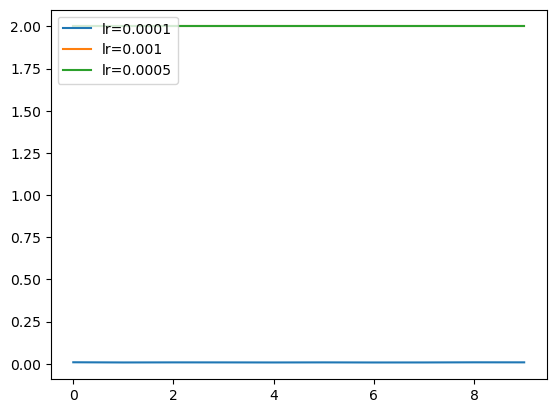

In [65]:
import matplotlib.pyplot as plt

for k, v in history.items():
    plt.plot(v, label = 'lr='+str(k))
    
plt.legend(loc="upper left")




In [55]:
y_pred = model_nn(X_test_t)

In [56]:
y_pred=y_pred.detach().numpy()

In [57]:
#TODO kell ez? 

X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)

In [58]:
y_pred=y_scaler.inverse_transform(y_pred)


In [59]:
eval_df_nn=evaluate_model(X_test, y_test, y_pred)

In [60]:
eval_df_nn.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
473704,3.0,0.433333,0.547323,0.980657,3.433333,3.547323,3.320096,26.305377,23.247682,3.265880
315382,2.0,-0.366667,-0.376412,0.743079,1.633333,1.623588,0.596629,2.657705,2.622852,0.598414
333825,2.0,0.300000,0.473591,0.773590,2.300000,2.473591,7.547451,57.863867,44.879391,7.272989
1112151,2.0,-0.416666,-0.491723,0.908389,1.583334,1.508277,4.740406,18.013567,16.525180,4.855491
725909,1.0,-0.399999,0.496260,0.096261,0.600001,1.496260,149.376413,224.065270,200.000000,85.510302


In [64]:
eval_df_nn[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE1 (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE1 (MENETIDO)
count,311547.000000,3.115470e+05,3.115470e+05,3.115470e+05,3.115470e+05,3.115470e+05
mean,-0.008364,1.005951e+00,2.160218e+04,1.923943e+07,6.952979e+01,1.480832e+01
std,0.906503,1.324650e+00,4.379115e+06,2.129158e+08,7.651936e+01,2.504035e+01
min,-6.133333,9.189049e-08,1.528324e-07,6.622746e-07,6.622746e-07,1.528324e-07
25%,-0.416666,3.033553e-01,1.547435e+00,5.317399e+00,5.384116e+00,1.551500e+00
50%,-0.116667,6.690370e-01,4.608151e+00,3.060437e+01,3.143152e+01,4.620408e+00
75%,0.216667,1.104972e+00,1.542673e+01,1.057128e+02,1.327017e+02,1.539424e+01
max,30.666667,3.511936e+01,1.174867e+09,1.532860e+10,2.000000e+02,2.000000e+02


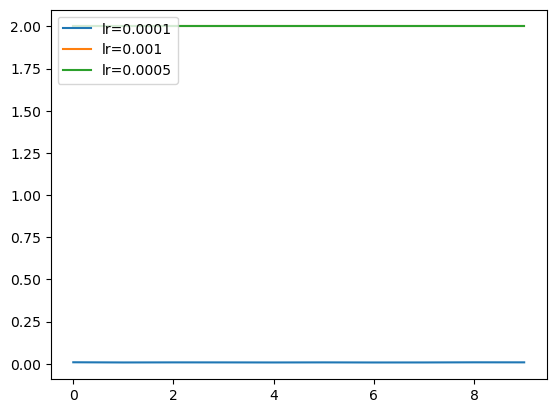

In [63]:
save_NN(model_nn,X_scaler,y_scaler,history,'Base')

In [ ]:
del model_nn

# Kisebb adaton:

most rendelkezésre álló adat:
- utastájékoztatásból terv- és tényídők
- időjárás

Azaz dobjuk a lassújel és vágányzár adatokat


In [ ]:
raw_data.columns

Index(['MENETREND_IDO', 'ELOZO_KESES', 'KESES', 'RELATIV_KESES',
       'TERV_IDOTARTAM (m)', 'tx', 't', 'tn', 'r', 'Érintett objektum típusa',
       'Lassúmenet típusa', 'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása', 'I',
       'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO VONAT KESES', 'ELOZO VONAT RELATIV KESES',
       'VONAL STATUSZ VALTOZOTT'],
      dtype='object')

In [ ]:
attrs_to_use=['MENETREND_IDO','ELOZO_KESES','KESES','tx','t','tn','r','TERV_IDOTARTAM (m)','ELOZO VONAT KESES','ELOZO VONAT RELATIV KESES']

In [ ]:
raw_data_small=raw_data[attrs_to_use]


In [ ]:
def train_and_evaluate_DRT(data):
    history=None
    X_scaler=None
    y_scaler=None
    X_train, X_test, y_train, y_test,_,_ = split_train_test(data)
    model, predictions = train_DRT(X_train,X_test, y_train)
    eval_df = evaluate_model(X_test, y_test, predictions)
    return model,eval_df,X_scaler,y_scaler,history





In [ ]:
raw_data_small.head()

In [ ]:
model_s,eval_df_s,_,_,_=train_and_evaluate_DRT(raw_data_small)

In [ ]:
eval_df_s[['AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

In [29]:
save_sklearn_model(model_s,'RT','Small')


In [30]:
del model_s

In [33]:
raw_data_small=raw_data[attrs_to_use]
def train_and_evaluate_NN(data, epoch=20, lr=0.0001):
    X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(data,True)
    X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)
    input_size=X_train.shape[1]
    model = get_NN_model(input_size)
    #optimizer, loss_fn = get_optimizer(model, lr)
    history, best_mse, best_weights, model=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model, None, None, epoch)
    y_pred = model(X_test_t)
    y_pred=y_pred.detach().numpy()
    X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
    y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)
    y_pred=y_scaler.inverse_transform(y_pred)
    eval_df_nn = evaluate_model(X_test, y_test, y_pred)
    return model,eval_df_nn,X_scaler,y_scaler,history


In [34]:
model_nn_s,eval_df_nn_s,X_scaler_s,y_scaler, history_s=train_and_evaluate_NN(raw_data_small,20)


    

C:\Users\ELTE\AppData\Local\Temp\ipykernel_18172\3857565312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


Epoch: 0 MSE: 3.41435479640495e-05 Best mse inf
Epoch: 1 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 2 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 3 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 4 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 5 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 6 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 7 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 8 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 9 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 10 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 11 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 12 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 13 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 14 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 15 MSE: 3.41435479640495e-05 B

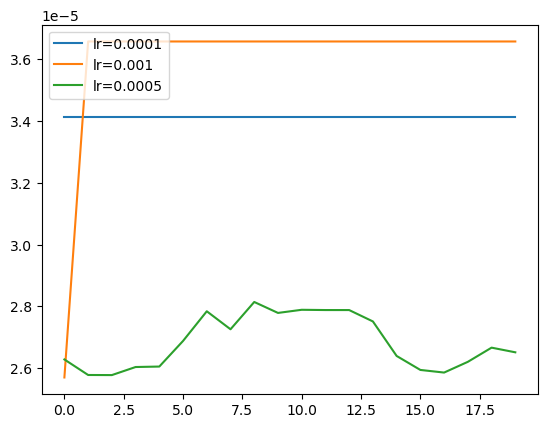

In [35]:
save_NN(model_nn_s,X_scaler_s,y_scaler,history_s,'Small')



In [36]:
eval_df_nn_s.head()

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
1096781,1.0,-2.833336e-01,-0.093632,0.716666,0.906368,-26.470010,26.470010,6.695345e+01,6.695345e+01
1016002,1.0,2.833343e-01,0.158543,1.283334,1.158544,9.723950,9.723950,4.404366e+01,4.404366e+01
53208,2.0,-6.666564e-02,0.946883,1.933334,2.946883,-52.424911,52.424911,1.520347e+03,1.520347e+03
1032627,1.0,-1.999996e-01,0.007799,0.800000,1.007799,-25.974796,25.974796,1.038994e+02,1.038994e+02
830943,3.0,3.164013e-07,0.248797,3.000000,3.248798,-8.293236,8.293236,-7.863340e+07,7.863340e+07


In [37]:
eval_df_nn_s[['MAPE','MAPE1']].describe()

,MAPE,MAPE1
count,3.347450e+05,3.347450e+05
mean,8.957245e+03,2.942559e+06
std,1.335253e+06,2.160184e+07
min,6.223986e-05,5.493332e-04
25%,6.226832e+00,4.523875e+01
50%,1.494601e+01,7.624991e+01
75%,3.200387e+01,1.394789e+02
max,2.748233e+08,8.690156e+08


In [38]:
del model_nn_s

In [39]:
del raw_data_small
del raw_data
    

# loading the models and validate them

In [23]:
import pandas as pd
from config import data_root

In [24]:
validation_data=pd.read_csv(data_root+'validation_data.csv')
y=validation_data['KESES']
X=validation_data.drop(columns=['KESES','RELATIV_KESES'])
X_additional=X[['VONATSZAM','KOZLEKEDESI_NAP']]
X.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
if 'KESES' in attrs_to_use:
    attrs_to_use.remove('KESES')
X_small=X[attrs_to_use]





In [75]:
#model/data_desc/model_desc
base_RT = load_sk_by_desc('RT','base','Base')['model']
small_RT = load_sk_by_desc('RT','base','Small')['model']


In [76]:
base_RT.feature_names_in_

array(['MENETREND_IDO', 'ELOZO_KESES', 'TERV_IDOTARTAM (m)', 'tx', 't',
       'tn', 'r', 'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása',
       'I', 'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO VONAT KESES', 'ELOZO VONAT RELATIV KESES',
       'VONAL STATUSZ VALTOZOTT'], dtype=object)

In [77]:
small_RT.feature_names_in_


array(['MENETREND_IDO', 'ELOZO_KESES', 'tx', 't', 'tn', 'r',
       'TERV_IDOTARTAM (m)', 'ELOZO VONAT KESES',
       'ELOZO VONAT RELATIV KESES'], dtype=object)

In [26]:
y_pred_dt_base=small_RT.predict(X_small)
#small_RT_res=evaluate_model(X_small,y,y_pred)



In [27]:
y_pred_dt_small=base_RT.predict(X)
#base_RT_res=evaluate_model(X,y,y_pred)

In [28]:
del small_RT
del base_RT

In [29]:
validation_data.head()

,VONATSZAM,MENETREND_IDO,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,t,tn,r,...,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
0,2019,241.0,1.166667,-0.216667,-0.216667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.550000,-0.550000,0.0,2022-01-01
1,2019,245.0,1.716667,0.133333,0.133333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,2022-01-01
2,2019,250.0,1.800000,-0.433333,-0.433333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.600000,-0.600000,0.0,2022-01-01
3,2019,256.0,2.366667,-0.383333,-0.383333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.583333,-0.583333,0.0,2022-01-01
4,2019,261.0,2.300000,0.416667,0.416667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.350000,-0.350000,0.0,2022-01-01


In [30]:
import torch
base_X_scaler=load_sk_by_desc('X_scaler','base','base')['model']
base_y_scaler=load_sk_by_desc('y_scaler','base','base')['model']

X_t = torch.tensor(base_X_scaler.transform(X), dtype=torch.float32)
nn_base=load_NN('./model/NN/base/base/')['model']
y_pred_nn_base=base_y_scaler.inverse_transform(nn_base(X_t).detach().numpy())
del base_X_scaler
del base_y_scaler
del nn_base
del X_t


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- RELATIV_KESES


In [ ]:
attrs_to_use

In [31]:


small_X_scaler=load_sk_by_desc('X_scaler','base','Small')['model']
small_y_scaler=load_sk_by_desc('y_scaler','base','Small')['model']

X_t = torch.tensor(small_X_scaler.transform(X_small), dtype=torch.float32)
nn_small=load_NN('./model/NN/Small/base/')['model']
y_pred_nn_small=small_y_scaler.inverse_transform(nn_small(X_t).detach().numpy())
del small_X_scaler
del small_y_scaler
del nn_small
del X_t



Unspecified file: history.png
Loading model: ./model/NN/Small/base/NN_Small_base.pth


In [32]:
#del y
del X
del X_small

In [33]:
names = ['P-NN-small','P-DT','P-DT-small','KESES']
#preds=[y_pred_nn_base.squeeze(),y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
preds=[y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
cols_to_add=pd.DataFrame(dict(zip(names,preds)))

In [ ]:
type(y_pred_dt_small[:5])

In [ ]:
y_pred_dt_small.reshape(1,).shape

In [ ]:
type(y_pred_nn_base[:5])

In [ ]:
y_pred_nn_base.squeeze().shape

In [34]:
df_to_validate_orig=pd.read_pickle(data_root+'validation_orig.pkl')
df_to_validate_orig.drop(columns=['KESES'], inplace=True)

In [35]:
df_to_validate_orig.reset_index(drop=True, inplace=True)
cols_to_add.reset_index(drop=True, inplace=True)

In [36]:
eval_df=pd.concat([df_to_validate_orig,cols_to_add], axis=1)

In [37]:
eval_df.head()

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP,P-NN-small,P-DT,P-DT-small,KESES
0,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-0.216667,1.0,14.1,...,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01,-0.021600,-0.381898,-0.381898,-0.216667
1,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0.133333,1.0,14.1,...,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01,-0.000548,-0.194139,-0.194139,0.133333
2,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-0.433333,1.0,14.1,...,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01,-0.027108,-0.372194,-0.372194,-0.433333
3,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-0.383333,1.0,14.1,...,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01,-0.029669,-0.372194,-0.372194,-0.383333
4,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0.416667,1.0,14.1,...,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01,-0.020017,-0.381898,-0.381898,0.416667


In [38]:
eval_df.to_pickle(data_root+'validation_res.pkl')

In [46]:
preds_=pd.read_pickle(data_root+'validation_res.pkl')


In [47]:
preds_

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP,P-NN-small,P-DT,P-DT-small,KESES
0,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-0.216667,1.0,14.1,...,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01,-0.021600,-0.381898,-0.381898,-0.216667
1,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0.133333,1.0,14.1,...,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01,-0.000548,-0.194139,-0.194139,0.133333
2,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-0.433333,1.0,14.1,...,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01,-0.027108,-0.372194,-0.372194,-0.433333
3,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-0.383333,1.0,14.1,...,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01,-0.029669,-0.372194,-0.372194,-0.383333
4,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0.416667,1.0,14.1,...,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01,-0.020017,-0.381898,-0.381898,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375751,147,37467,1953,2023-12-24 08:03:00,08:04:00,0 days 00:00:03,0 days 00:00:30,-0.450000,1.0,0.0,...,0.0,0.0,0 days 00:00:47,0.783333,False,2023-12-24,0.320030,0.135181,0.135181,-0.450000
375752,147,37467,1953,2023-12-24 08:04:00,08:09:00,0 days 00:00:35,0 days 00:00:03,0.106667,5.0,0.0,...,0.0,0.0,0 days 00:00:01,0.003333,False,2023-12-24,0.136535,0.027540,0.027540,0.533333
375753,147,37467,1953,2023-12-24 08:09:00,08:14:00,0 days 00:00:06,0 days 00:00:47,-0.136667,5.0,0.0,...,0.0,0.0,-1 days +23:59:18,-0.140000,False,2023-12-24,-0.309108,-0.638815,-0.638815,-0.683333
375754,147,37467,1953,2023-12-24 08:14:00,08:25:00,0 days 00:00:31,0 days 00:00:19,0.018182,11.0,0.0,...,0.0,0.0,0 days 00:00:07,0.010606,False,2023-12-24,0.181106,0.200716,0.200716,0.200000


In [48]:
preds.columns

AttributeError: 'list' object has no attribute 'columns'

In [95]:
eval_df=preds_.copy()

In [96]:
eval_df['KOZLEKEDESI_NAP']=pd.to_datetime(eval_df['ELOZO_ESEMENY_IDO']).dt.date
eval_df['TENY_IDOTARTAM']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES']
if 'KESES' in names:
    names.remove('KESES')
eval_df=eval_df[['VONATSZAM','KOZLEKEDESI_NAP','KESES','OSSZ_KESES','TENY_IDOTARTAM','TERV_IDOTARTAM (m)']+names]
metrics=[]
aes=[]
ape_stat_s=[]
apes_delay_s=[]
for n in names:
    print(n)
    eval_df['JOSOLT_IDOTARTAM ' + n]=eval_df['TERV_IDOTARTAM (m)']+eval_df[n]
    
    # menetido alapján
    eval_df[f'{n} AE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])
    metrics.append(f'{n} AE (MENETIDO)')
    aes.append(f'{n} AE (MENETIDO)')

    eval_df[f'{n} APE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])/eval_df['TENY_IDOTARTAM'] *100
    metrics.append(f'{n} APE (MENETIDO)')
    ape_stat_s.append(f'{n} APE (MENETIDO)')

    eval_df[f'{n} APE (KESES)']=abs(eval_df['KESES']-eval_df[n])/eval_df['KESES'] *100
    metrics.append(f'{n} APE (KESES)')
    apes_delay_s.append(f'{n} APE (KESES)')



P-NN-small
P-DT
P-DT-small


In [ ]:
eval_df

In [81]:
ae_res=eval_df[aes].describe()

In [83]:
print(ae_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small AE (MENETIDO) & P-DT AE (MENETIDO) & P-DT-small AE (MENETIDO) \\
\midrule
count & 375756.000000 & 375756.000000 & 375756.000000 \\
mean & 0.376994 & 0.272791 & 0.272951 \\
std & 0.616813 & 0.579716 & 0.580614 \\
min & 0.000007 & 0.000000 & 0.000000 \\
25% & 0.120238 & 0.058766 & 0.058766 \\
50% & 0.253240 & 0.139245 & 0.139290 \\
75% & 0.428092 & 0.290157 & 0.290157 \\
max & 79.268958 & 79.457042 & 79.457042 \\
\bottomrule
\end{tabular}



In [74]:
eval_df[metrics].describe()

,P-NN-small AE (MENETIDO),P-NN-small APE (MENETIDO),P-NN-small APE (KESES),P-DT AE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),P-DT-small AE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
count,375756.000000,3.757560e+05,3.757560e+05,375756.000000,3.632570e+05,3.632530e+05,375756.000000,3.632570e+05,3.632530e+05
mean,0.376994,inf,inf,0.272791,inf,inf,0.272951,inf,inf
std,0.616813,NaN,NaN,0.579716,NaN,NaN,0.580614,NaN,NaN
min,0.000007,-1.637744e+04,-1.532330e+04,0.000000,-1.489422e+04,-1.975000e+04,0.000000,-1.489422e+04,-1.975000e+04
25%,0.120238,6.475098e+00,-7.748312e+01,0.058766,3.141642e+00,-4.941619e+01,0.058766,3.141642e+00,-4.941619e+01
50%,0.253240,1.569051e+01,-2.933776e+01,0.139245,8.181594e+00,-7.407380e+00,0.139290,8.181594e+00,-7.407380e+00
75%,0.428092,3.673366e+01,9.072160e+01,0.290157,2.142627e+01,6.349195e+01,0.290157,2.142627e+01,6.349195e+01
max,79.268958,inf,inf,79.457042,inf,inf,79.457042,inf,inf


In [101]:
eval_df_restrcited=eval_df[(eval_df['KESES']>5) & (eval_df['TERV_IDOTARTAM (m)']>10)]

In [102]:
eval_df_restrcited.head()

,VONATSZAM,KOZLEKEDESI_NAP,KESES,OSSZ_KESES,TENY_IDOTARTAM,TERV_IDOTARTAM (m),P-NN-small,P-DT,P-DT-small,JOSOLT_IDOTARTAM P-NN-small,...,P-NN-small APE (MENETIDO),P-NN-small APE (KESES),JOSOLT_IDOTARTAM P-DT,P-DT AE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),JOSOLT_IDOTARTAM P-DT-small,P-DT-small AE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
127525,2034,2023-04-15,7.250000,0 days 00:08:38,60.250000,53.0,-0.827470,0.285190,0.285190,52.172530,...,13.406589,111.413379,53.285190,6.964810,11.559850,96.066341,53.285190,6.964810,11.559850,96.066341
128051,2067,2023-04-15,7.033333,0 days 00:09:19,60.033333,53.0,-0.805491,0.285190,0.285190,52.194509,...,13.057453,111.452474,53.285190,6.748143,11.240660,95.945162,53.285190,6.748143,11.240660,95.945162
128170,2077,2023-04-15,5.033333,0 days 00:05:35,58.033333,53.0,-0.755018,0.000000,0.000000,52.244982,...,9.974184,115.000356,53.000000,5.033333,8.673176,100.000000,53.000000,5.033333,8.673176,100.000000
224816,32619,2023-04-01,11.433333,0 days 00:14:12,24.433333,13.0,-0.428698,-0.907062,-0.907062,12.571302,...,48.548559,103.749545,12.092938,12.340396,50.506394,107.933489,12.092938,12.340396,50.506394,107.933489
224819,32619,2023-04-01,5.650000,0 days 00:21:25,18.650000,13.0,-0.273311,-0.712405,-0.712405,12.726689,...,31.760383,104.837372,12.287595,6.362405,34.114775,112.608946,12.287595,6.362405,34.114775,112.608946


In [103]:
ape_stat_res=eval_df_restrcited[ape_stat_s].describe()

In [104]:
print(ape_stat_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small APE (MENETIDO) & P-DT APE (MENETIDO) & P-DT-small APE (MENETIDO) \\
\midrule
count & 12.000000 & 12.000000 & 12.000000 \\
mean & 25.175177 & 24.816343 & 24.816343 \\
std & 14.705735 & 16.129392 & 16.129392 \\
min & 9.974184 & 8.673176 & 8.673176 \\
25% & 13.057453 & 11.240660 & 11.240660 \\
50% & 22.583486 & 22.181527 & 22.181527 \\
75% & 34.303893 & 34.114775 & 34.114775 \\
max & 48.548559 & 50.506394 & 50.506394 \\
\bottomrule
\end{tabular}



In [105]:
apes_delay_res=eval_df_restrcited[apes_delay_s].describe()
print(apes_delay_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small APE (KESES) & P-DT APE (KESES) & P-DT-small APE (KESES) \\
\midrule
count & 12.000000 & 12.000000 & 12.000000 \\
mean & 106.593949 & 100.265201 & 100.265201 \\
std & 7.513354 & 8.241808 & 8.241808 \\
min & 93.110566 & 89.037267 & 89.037267 \\
25% & 103.749545 & 95.945162 & 95.945162 \\
50% & 108.125375 & 98.033171 & 98.033171 \\
75% & 111.452474 & 107.933489 & 107.933489 \\
max & 115.000356 & 112.608946 & 112.608946 \\
\bottomrule
\end{tabular}



# Spearman

In [29]:
from config import data_root
import pandas as pd

In [30]:
s_validation_data=pd.read_pickle(data_root+'validation_orig.pkl')



In [37]:
s_validation_data[]

,VONAL,VONATSZAM,KOZLEKEDESI_NAP,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT
47,2,2019,2022-01-01,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-1 days +23:59:47,-0.216667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:27,-0.550000,False
50,2,2019,2022-01-01,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0 days 00:00:08,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:04,0.066667,False
52,2,2019,2022-01-01,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-1 days +23:59:34,-0.433333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:24,-0.600000,False
56,2,2019,2022-01-01,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-1 days +23:59:37,-0.383333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:25,-0.583333,False
60,2,2019,2022-01-01,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0 days 00:00:25,0.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:39,-0.350000,False


In [40]:
import datetime    
def previous_data_and_route(date_and_time:datetime.datetime, train_no=None):
    #todo live
    if train_no:
        print(train_no)
        schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==pd.to_datetime(date_and_time.date())) & (s_validation_data['VONATSZAM'].isin(train_no))]
    else:
        schedule=s_validation_data[s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date() ]
    #ELOZO_ESEMENY_IDO= tervezett idő
    schedule['TENY_IDO']=pd.to_datetime(date_and_time.date()) + pd.to_timedelta(schedule['MENETREND_IDO'].astype(str))+schedule['OSSZ_KESES']    
    schedule['ELOZO_TENY_IDO']=schedule['ELOZO_ESEMENY_IDO']+schedule['OSSZ_KESES']-schedule['KESES']
    actual_record=schedule[(schedule['ELOZO_TENY_IDO']<=date_and_time) & (schedule['TENY_IDO']>date_and_time)]
    
    schedule_past=schedule[schedule['ELOZO_TENY_IDO']<=date_and_time]
    schedule_future=schedule[schedule['ELOZO_TENY_IDO']>date_and_time]
    return schedule,schedule_past,schedule_future,actual_record

    

def predict(date:datetime.date,time:datetime.time=None,number:int=None):
    dt = datetime.datetime.combine(date, time)
    schedule,schedule_past,schedule_future,actual_record=previous_data_and_route(dt,number)
    return schedule,schedule_past,schedule_future,actual_record
    
    
train_no=[2019]

date=datetime.date(2023,7,3)
time=datetime.time(4,15)
schedule,schedule_past,schedule_future,actual_record=predict(date,time,train_no)

    

[2019]


C:\Users\ELTE\AppData\Local\Temp\ipykernel_26572\2646471546.py:10: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  schedule['TENY_IDO']=pd.to_datetime(date_and_time.date()) + pd.to_timedelta(schedule['MENETREND_IDO'].astype(str))+schedule['OSSZ_KESES']


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'float'

In [41]:
 
date_and_time=datetime.datetime.combine(date, time)
schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']== pd.to_datetime(date_and_time.date())) ]
#schedule['TENY_IDO']=pd.to_datetime(date_and_time.date()) + pd.to_timedelta(schedule['MENETREND_IDO'].astype(str))+schedule['OSSZ_KESES']   
#res=schedule.head().apply(lambda r : datetime.datetime.combine(r['KOZLEKEDESI_NAP'],r['MENETREND_IDO']),1)
#res

In [42]:
schedule

,VONAL,VONATSZAM,KOZLEKEDESI_NAP,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT
2004612,70,2010,2023-07-03,465,0.0,00:25:00,0 days 00:00:00,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False
2004613,70,2010,2023-07-03,465,2023-07-03 00:25:00,00:30:00,0 days 00:01:48,0 days 00:00:00,0 days 00:01:48,0.360000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:58,-0.006667,False
2004614,2,2010,2023-07-03,465,2023-07-03 00:30:00,00:31:00,0 days 00:01:32,0 days 00:01:48,-1 days +23:59:44,-0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:28,-0.533333,False
2004615,2,2010,2023-07-03,465,2023-07-03 00:31:00,00:36:00,0 days 00:01:05,0 days 00:01:32,-1 days +23:59:33,-0.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:58:48,-0.240000,False
2004616,2,2010,2023-07-03,465,2023-07-03 00:36:00,00:37:00,0 days 00:00:40,0 days 00:01:05,-1 days +23:59:35,-0.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:29,0.483333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107527,147,37461,2023-07-03,1953,2023-07-03 17:23:00,17:24:00,0 days 00:00:09,-1 days +23:59:48,0 days 00:00:21,0.350000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:36,-0.400000,False
107528,147,37461,2023-07-03,1953,2023-07-03 17:24:00,17:29:00,0 days 00:00:21,0 days 00:00:09,0 days 00:00:12,0.040000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:03,0.010000,False
107530,147,37461,2023-07-03,1953,2023-07-03 17:29:00,17:34:00,-1 days +23:59:59,0 days 00:00:41,-1 days +23:59:18,-0.140000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:11,-0.163333,False
107532,147,37461,2023-07-03,1953,2023-07-03 17:34:00,17:45:00,0 days 00:00:35,0 days 00:00:23,0 days 00:00:12,0.018182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:48,-0.018182,False


In [34]:
schedule[schedule['MENETREND_IDO'].map(type) == float]

,VONAL,VONATSZAM,KOZLEKEDESI_NAP,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT


In [36]:
schedule

,VONAL,VONATSZAM,KOZLEKEDESI_NAP,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT


In [35]:
train_no=[2019]

date=datetime.date(2023,7,3)
time=datetime.time(4,15)
date_and_time = datetime.datetime.combine(date, time)

schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date()) & (s_validation_data['VONATSZAM'].isin(train_no))]


In [36]:
schedule

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),...,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
2004926,2,2019,465,2023-07-03 03:56:00,04:00:00,0 days 00:01:16,0 days 00:00:37,0 days 00:00:39,0.162500,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:16,0.066667,False,2023-07-03
2004927,2,2019,465,2023-07-03 04:00:00,04:01:00,0 days 00:00:56,0 days 00:01:16,-1 days +23:59:40,-0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:47,-0.216667,False,2023-07-03
2004928,2,2019,465,2023-07-03 04:01:00,04:02:00,0 days 00:01:02,0 days 00:00:56,0 days 00:00:06,0.100000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:04,0.066667,False,2023-07-03
2004929,2,2019,465,2023-07-03 04:02:00,04:04:00,0 days 00:01:46,0 days 00:01:02,0 days 00:00:44,0.366667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:48,0.400000,False,2023-07-03
2004930,2,2019,465,2023-07-03 04:04:00,04:05:00,0 days 00:01:32,0 days 00:01:46,-1 days +23:59:46,-0.233333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:41,-0.316667,False,2023-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852388,2,2019,465,2023-07-03 04:56:00,04:57:00,0 days 00:02:55,0 days 00:03:16,-1 days +23:59:39,-0.350000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:35,-0.416667,False,2023-07-03
852389,2,2019,465,2023-07-03 04:57:00,05:01:00,0 days 00:04:09,0 days 00:02:55,0 days 00:01:14,0.308333,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,2023-07-03
852390,70,2019,465,2023-07-03 05:01:00,05:02:00,0 days 00:03:49,0 days 00:04:09,-1 days +23:59:40,-0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,2023-07-03
852391,70,2019,465,2023-07-03 05:02:00,05:08:00,0 days 00:03:00,0 days 00:03:49,-1 days +23:59:11,-0.136111,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:56,-0.011111,False,2023-07-03


C:\Users\ELTE\AppData\Local\Temp\ipykernel_6344\2311804087.py:1: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  schedule['OSSZ_KESES'].map(pd.Timedelta.to_pytimedelta)+schedule['MENETREND_IDO']


TypeError: unsupported operand type(s) for +: 'Timedelta' and 'datetime.time'

In [163]:
actual_record=schedule[(schedule['ELOZO_TENY_IDO']<=date_and_time) & (schedule['MENETREND_IDO']+schedule['OSSZ_KESES'].map(pd.Timedelta.to_pytimedelta)>date_and_time)]

C:\Users\ELTE\AppData\Local\Temp\ipykernel_6344\77241690.py:1: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  actual_record=schedule[(schedule['ELOZO_TENY_IDO']<=date_and_time) & (schedule['MENETREND_IDO']+schedule['OSSZ_KESES'].map(pd.Timedelta.to_pytimedelta)>date_and_time)]


TypeError: unsupported operand type(s) for +: 'Timedelta' and 'datetime.time'

In [150]:
schedule_past

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),...,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP,ELOZO_TENY_IDO


In [139]:
s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date())]

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),...,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
47,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-1 days +23:59:47,-0.216667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01
50,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0 days 00:00:08,0.133333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01
52,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-1 days +23:59:34,-0.433333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01
56,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-1 days +23:59:37,-0.383333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01
60,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0 days 00:00:25,0.416667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,147,37467,1953,2022-01-01 07:52:00,08:03:00,0 days 00:01:11,0 days 00:00:03,0 days 00:01:08,0.103030,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:01:30,0.136364,False,2022-01-01
460,147,37467,1953,2022-01-01 08:03:00,08:04:00,0 days 00:00:28,0 days 00:01:11,-1 days +23:59:17,-0.716667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:19,-0.683333,False,2022-01-01
461,147,37467,1953,2022-01-01 08:04:00,08:09:00,0 days 00:00:33,0 days 00:00:28,0 days 00:00:05,0.016667,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:09,0.030000,False,2022-01-01
463,147,37467,1953,2022-01-01 08:09:00,08:14:00,0 days 00:00:05,0 days 00:00:47,-1 days +23:59:18,-0.140000,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:18,-0.140000,False,2022-01-01


In [134]:
pd.to_datetime(s_validation_data['KOZLEKEDESI_NAP']).head()

47   2022-01-01
50   2022-01-01
52   2022-01-01
56   2022-01-01
60   2022-01-01
Name: KOZLEKEDESI_NAP, dtype: datetime64[ns]

In [138]:
date_and_time.date()

datetime.date(2022, 1, 1)

In [26]:
s_validation_data.head()

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),...,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
47,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-1 days +23:59:47,-0.216667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01
50,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0 days 00:00:08,0.133333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01
52,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-1 days +23:59:34,-0.433333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01
56,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-1 days +23:59:37,-0.383333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01
60,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0 days 00:00:25,0.416667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01


In [174]:
print('hello')

hello
